In [10]:
import numpy as np
import gym
from matplotlib import pyplot as plt

In [2]:
from tiles3 import tiles, IHT  # This is the package for constructing the feature tilings.

In [3]:
def action_selector(actions, values, epsilon):
    """ An epsilon-greedy action selector.
        Give list of actions, assumed values for each action,
            and probability of NOT acting greedily.
    """
    greedy = np.random.choice([1,0], p=[1-epsilon, epsilon])
    if greedy:
        return actions[3 - np.argmax(values[::-1]) - 1] # argmax in reverse to favor right action (not left)
    else:
        return np.random.choice(actions)

In [7]:
n_episodes = 100
n_timesteps = 1500  # Has to be this long to let it win by accident a few times, to start learning.
n_tilings = 10
tiling_dim = 10
max_tile_size = 1024 # ?? how to pick
iht = IHT(max_tile_size)

In [8]:
env = gym.make('MountainCar-v0')
env._max_episode_steps = n_timesteps
n_action = env.action_space.n
obs_highs = env.observation_space.high
obs_lows = env.observation_space.low
scales = [tiling_dim / (obs_highs[i] - obs_lows[i]) for i in range(len(obs_highs))]


# Tiling helper function
# Because the tiles code only divides at integers, we must scale our observations to tiling_dim x tiling_dim space
# We also must shift to the section of theta corresponding to the considered action.
def mytiles(pt, a):
    """ pt, point in observation space
        a, an action
        Returns featues for this state-action pair
    """
    pt_ = np.array([p*scales[i] for i,p in enumerate(list(pt))])
    features = list(np.array(tiles(iht, n_tilings, pt_)) + a * max_tile_size)
    phi = np.zeros_like(theta)
    phi[features] = 1
    return phi

# init weights
theta = np.zeros(max_tile_size *  3) # basically a full set of weights per action, all concatenated together
# theta = np.random.normal(0, .1, max_tile_size * 3)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [9]:
# params
epsilon = .6 # (greedy)
gamma = .99
lam = .9
alpha = .1
actions = range(env.action_space.n)

# Run the learning loop
rewards = []
for i_episode in range(n_episodes):
    epsilon *= .95
    epsilon = max(epsilon, .1)
    observation = env.reset()
    
    # Choose an action espilon-greedily
    phis = [mytiles(observation, a) for a in actions] # get features for observation
    q_vals = [theta.dot(phi) for phi in phis]
    action = action_selector(actions, q_vals, epsilon)
    phi_sa = phis[action]
    q_sa = q_vals[action]

    # initialize e = 0
    e = np.zeros_like(theta)
    
    for t in range(n_timesteps):
#         env.render()
        
        # Take action, observe change, choose new a, get new features and q_sa_ and do update
        
        observation, reward, done, info = env.step(action)
        
        # Choose next action epsilon-greedily
        phis = [mytiles(observation, a) for a in actions]
        q_vals = [theta.dot(phi) for phi in phis]
        action = action_selector(actions, q_vals, epsilon)
        phi_sa_ = phis[action]
        q_sa_ = q_vals[action]
        
#         if done: q_sa_ = 0 #????
        
        # Perform updates
        d = reward + gamma * q_sa_ - q_sa
        e = gamma * lam * e + alpha * (1 - gamma * lam * e.dot(phi_sa)) * phi_sa
        theta = theta + d * e + alpha * (q_sa - theta.dot(phi_sa)) * phi_sa
        
        
        q_sa = q_sa_
        phi_sa = phi_sa_
        
    
        if done:
            rewards.append(t+1)
            print("Episode finished after {} timesteps".format(t+1))
            break
    
env.close()

Episode finished after 935 timesteps
Episode finished after 1500 timesteps
Episode finished after 1031 timesteps
Episode finished after 684 timesteps
Episode finished after 571 timesteps
Episode finished after 1170 timesteps
Episode finished after 768 timesteps
Episode finished after 788 timesteps
Episode finished after 749 timesteps
Episode finished after 317 timesteps
Episode finished after 394 timesteps
Episode finished after 869 timesteps
Episode finished after 267 timesteps
Episode finished after 410 timesteps
Episode finished after 441 timesteps
Episode finished after 347 timesteps
Episode finished after 367 timesteps
Episode finished after 677 timesteps
Episode finished after 468 timesteps
Episode finished after 269 timesteps
Episode finished after 506 timesteps
Episode finished after 823 timesteps
Episode finished after 828 timesteps
Episode finished after 532 timesteps
Episode finished after 490 timesteps
Episode finished after 281 timesteps
Episode finished after 399 timestep

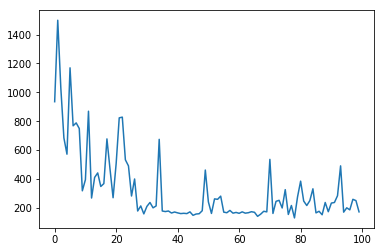

In [11]:
plt.plot(rewards)

In [ ]:
# Ways to combine state features with actions

# three separate theta vectors ? one per action? noooo
# include as nother dimension in tiling?  Not clear how--actions are discrete
# one theta, three times as long, each phi *= action*max_state_size)  <-- current implementation

# Q: check: was it just the bigger gamma (.99) or the reverse argmax????  Try each

In [ ]:
values = [2,1,1]
np.argmax(values)

In [ ]:
3 - np.argmax(values[::-1]) - 1

In [ ]:
sum(np.random.normal(0, .1, 150))